In [1]:
import nltk
import sklearn_crfsuite
import eli5

In [34]:
def greater(word,lim):
    count=0
    for i in word:
        if(i.isdigit()):
            count+=1
    return count>=lim

In [285]:
greater("anke12",3)

False

In [40]:
def read_data(data_path,label=True):
    x=[]
    y=[]
    with open(data_path,'r') as f:
        tokens=[]
        labels=[]
        count=0
        for token in f:
            count+=1
            if(count%10000==0):
                print(count)
            token=token.strip().split(" ")
            if(len(token)==1 and token[0]==''):
                x.append(list(tokens))
                y.append(list(labels))
                tokens=[]
                labels=[]
                
            else:
                tokens.append(token[0])
                labels.append(token[1])
    return x,y

def get_pos(x):
    new_x=[]
    for sent in x:
        new_x.append(nltk.pos_tag(sent))
    return new_x

In [4]:
x_train,y_train=read_data("data/space_data/train.txt")
x_val,y_val=read_data("data/space_data/val.txt")
x_test,y_test=read_data("data/space_data/test.txt")

10000
20000
30000
40000
50000
60000
70000
10000


In [5]:
train_pos=get_pos(x_train)
val_pos=get_pos(x_val)
test_pos=get_pos(x_test)

In [6]:
print(train_pos[0:5])

[[('250metr', 'CD'), ('single', 'JJ'), ('story', 'NN'), ('noida', 'JJ'), ('#Sec99', 'NN'), ('for', 'IN'), ('sale', 'NN'), ('@90k', 'CD'), ('/metr', 'NN')], [('Dale', 'NNP'), ('ajay', 'NN'), ('Yadav', 'NNP'), ('90', 'CD'), ('MTR', 'NNP'), ('roof', 'NN'), ('right', 'JJ'), ('floor', 'NN'), ('3b+2t', 'CD'), ('shakti', 'NN'), ('khand', 'NN'), ('-4', 'NNP'), ('Demand', 'NNP'), ('-48', 'NNP'), ('lack/', 'NN')], [('in', 'IN'), ('kothi', '$'), ('1', 'CD'), ('rk', 'NN'), ('for', 'IN'), ('rent', 'NN'), ('#Sector55', 'NNP'), ('noida', 'CC'), ('marble', 'JJ'), ('floor', 'NN'), ('-', ':'), ('http://olx.in/item/in-kothi-1-rk-for-rent-#Sector55-noida-marble-floor-IDYE6ww.html', 'NN')], [('#Sec48', 'NN'), (',', ','), ('noida', 'JJ'), ('Residential', 'NNP'), ('Plot', 'NNP'), ('-450', 'NNP'), ('sq', 'NN'), ('.', '.'), ('meter', 'JJ'), ('Price', 'NNP'), ('demand', 'NN'), (':', ':'), ('Rs', 'NNP'), ('.', '.'), ('4.28', 'CD'), ('Cr', 'NNP'), ('.', '.')], [('Need', 'VB'), ('4000-5000sq', 'JJ'), ('ft', 'NN'),

In [244]:
def hassec(word):
    return 'sec' in word.lower()

In [245]:
def hashttp(word):
    return 'http' in word.lower()

In [246]:
def hasgen(word,st):
    return st in word.lower()

In [247]:
def hasPfeat(word):
    word=word.lower()
    if 'lac' in word or 'cr ' in word or 'rs' in word or 'lakh' in word or 'crore' in word:
        return True
    return False
    

In [481]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-4:]': word[-4:],        
        'word[:2]': word[:2],        
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
        'digit>=8': greater(word,8),
        'digit>=3': greater(word,3),
        'hassec': hassec(word),
        'hashttp': hashttp(word),
        'hasPfeat': hasPfeat(word),
        'hasbhk': hasgen(word,'bhk'),
        'hassq': hasgen(word,'sq'),
        'has/': hasgen(word,'/'),
        'has@': hasgen(word,'@'),
        'per': hasgen(word,'per'),
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
#             '-1word[-3:]': word1[-3:],
#             '-1word[-2:]': word1[-2:],
#             '-1word[:2]': word1[:2],        
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1digit>=8': greater(word1,8),
            '-1digit>=3': greater(word1,3),            
            '-1hassec': hassec(word1),
            '-1hashttp': hashttp(word1),
            '-1hasPfeat': hasPfeat(word1),
            '-1hasbhk': hasgen(word1,'bhk'),
            '-1hassq': hasgen(word1,'sq'),        
            '-1has/': hasgen(word1,'/'),
            '-1has@': hasgen(word1,'@'),
            '-1per': hasgen(word1,'per') or ((i>1)and hasgen(sent[i-2][0],'per')),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
#             '+1word[-3:]': word1[-3:],
#             '+1word[-2:]': word1[-2:],
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1digit>=8': greater(word1,8),
            '+1digit>=3': greater(word1,3),
            '+1hassec': hassec(word1),
            '+1hashttp': hashttp(word1),
            '+1hasPfeat': hasPfeat(word1),
            '+1hasbhk': hasgen(word1,'bhk'),
            '+1hassq': hasgen(word1,'sq'),        
            '+1has/': hasgen(word1,'/'),
            '+1has@': hasgen(word1,'@'),
            '+1per': hasgen(word1,'per') or ((i<len(sent)-2)and hasgen(sent[i+2][0],'per')),
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]


In [482]:
train_feat=[sent2features(x) for x in train_pos]
val_feat=[sent2features(x) for x in val_pos]
test_feat=[sent2features(x) for x in test_pos]

In [483]:
train_feat[0]

[{'bias': 1.0,
  'word.lower()': '250metr',
  'word[-3:]': 'etr',
  'word[-2:]': 'tr',
  'word[-4:]': 'metr',
  'word[:2]': '25',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'CD',
  'postag[:2]': 'CD',
  'digit>=8': False,
  'digit>=3': True,
  'hassec': False,
  'hashttp': False,
  'hasPfeat': False,
  'hasbhk': False,
  'hassq': False,
  'has/': False,
  'has@': False,
  'per': False,
  'BOS': True,
  '+1:word.lower()': 'single',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'JJ',
  '+1:postag[:2]': 'JJ',
  '+1digit>=8': False,
  '+1digit>=3': False,
  '+1hassec': False,
  '+1hashttp': False,
  '+1hasPfeat': False,
  '+1hasbhk': False,
  '+1hassq': False,
  '+1has/': False,
  '+1has@': False,
  '+1per': False},
 {'bias': 1.0,
  'word.lower()': 'single',
  'word[-3:]': 'gle',
  'word[-2:]': 'le',
  'word[-4:]': 'ngle',
  'word[:2]': 'si',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit(

In [525]:
train_val=train_feat+val_feat
train_val_y=y_train+y_val
crf = sklearn_crfsuite.CRF(
    algorithm='pa',
#     c1=0.1,
#     c2=0.1,
    max_iterations=25,
    all_possible_transitions=True,
)


In [526]:
crf.fit(train_val, train_val_y)

CRF(algorithm='pa', all_possible_states=None, all_possible_transitions=True,
  averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
  calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=25,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [527]:
labels = list(crf.classes_)
print(labels)

['LA', 'O', 'L', 'A', 'C', 'N', 'P', 'T']


In [528]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [529]:
def post_process(x,y):
    for i in range(len(x)):
        sent=x[i]
#         print("Sent",sent)
        for j in range(len(sent)):
            word=sent[j]
            if 'http' in word.lower():
                y[i][j]='O'
#             elif greater(word,8):
#                 y[i][j]='T'          
                

In [530]:
def evaluate(crf,test_feat,y_test,clean=False,x=None):
    y_pred = crf.predict(test_feat)
    if(clean):
        post_process(x,y_pred)
        
    print(metrics.flat_f1_score(y_test, y_pred,average='weighted', labels=labels))
    sorted_labels = sorted(
        labels,
        key=lambda name: (name[1:], name[0])
    )
    print(metrics.flat_classification_report(
        y_test, y_pred, labels=sorted_labels, digits=3
    ))

In [531]:
evaluate(crf,test_feat,y_test)
# evaluate(crf,test_feat,y_test,True,x_test)

0.8111501580460055
              precision    recall  f1-score   support

           A      0.752     0.686     0.718      2610
           C      0.780     0.622     0.692       320
           L      0.789     0.797     0.793      1820
           N      0.872     0.751     0.807       353
           O      0.827     0.864     0.845      6674
           P      0.767     0.751     0.759       413
           T      0.948     0.960     0.954       302
          LA      0.864     0.888     0.876      1027

   micro avg      0.813     0.813     0.813     13519
   macro avg      0.825     0.790     0.805     13519
weighted avg      0.811     0.813     0.811     13519



In [532]:
evaluate(crf,train_val,train_val_y)

0.8815123005153787
              precision    recall  f1-score   support

           A      0.849     0.788     0.818     16151
           C      0.866     0.808     0.836      1726
           L      0.874     0.888     0.881     10936
           N      0.904     0.869     0.886      2218
           O      0.886     0.914     0.900     39507
           P      0.889     0.839     0.863      2446
           T      0.974     0.961     0.967      1722
          LA      0.918     0.938     0.928      6188

   micro avg      0.882     0.882     0.882     80894
   macro avg      0.895     0.875     0.885     80894
weighted avg      0.882     0.882     0.882     80894



In [508]:
eli5.show_weights(crf, top=5, show=['transition_features'])


From \ To,A,C,L,LA,N,O,P,T
A,0.398,-0.076,-0.038,-0.015,-0.083,0.028,0.007,-0.196
C,-0.074,0.564,-0.083,-0.067,-0.198,0.022,-0.203,-0.061
L,0.012,-0.119,0.472,0.01,-0.026,0.018,-0.059,-0.221
LA,0.01,-0.048,-0.129,0.416,-0.162,-0.003,-0.066,0.077
N,-0.136,-0.158,-0.009,-0.11,0.388,-0.01,-0.19,0.056
O,0.051,-0.052,0.008,0.014,0.055,0.238,0.049,-0.024
P,-0.073,-0.078,-0.079,-0.122,-0.087,0.005,0.417,-0.163
T,-0.187,-0.066,-0.027,-0.148,0.007,-0.042,-0.056,0.422


In [474]:
eli5.show_weights(crf, top=20, targets=labels)

In [475]:
dicti={}
for l in labels:
    dicti[l]=[]
y_pred = crf.predict(test_feat)
for i in range(len(x_test)):
    for j in range(len(x_test[i])):
        if(y_pred[i][j]!=y_test[i][j]):
            dicti[y_test[i][j]].append((x_test[i][j],y_pred[i][j]))

In [476]:
lab='C'
print(len(dicti[lab]))
print(dicti[lab])

116
[('35', 'P'), ('55', 'P'), ('/', 'O'), ('sft', 'O'), ('@5900', 'P'), ('-8300', 'O'), ('approx', 'O'), ('Rs@', 'P'), ('.', 'O'), ('10000', 'LA'), ('sq', 'LA'), ('.', 'LA'), ('yard', 'LA'), ('RS-', 'L'), ('4500', 'LA'), ('sqft', 'LA'), ('@5600', 'O'), ('@5600', 'O'), ('@5600', 'O'), ('@5000', 'P'), ('/-', 'O'), ('5800', 'P'), ('@1', 'P'), ('.', 'P'), ('10.000', 'P'), ('@2750', 'P'), ('sft', 'O'), ('@4000', 'P'), ('.', 'O'), ('@6200', 'P'), ('rupees', 'O'), ('13000', 'O'), ('rs', 'P'), ('4500', 'LA'), ('psft', 'LA'), ('@4650', 'O'), ('1182', 'LA'), ('sq/ft', 'LA'), (',', 'O'), ('BSP', 'O'), ('3100', 'LA'), ('sq/ft', 'LA'), ('@16000', 'P'), ('@80000', 'P'), ('/', 'O'), ('call', 'O'), ('1.70', 'P'), ('k', 'P'), ('pm', 'P'), ('Rs', 'O'), ('.', 'O'), ('18000/-', 'O'), ('.', 'O'), ('12', 'O'), ('6500', 'O'), ('to', 'O'), ('6800', 'O'), ('only', 'O'), ('sft', 'LA'), ('15K', 'O'), ('4500/sqft', 'LA'), ('200', 'LA'), ('sq', 'LA'), ('mtr', 'LA'), ('3100', 'O'), ('4800', 'O'), ('@5250', 'P'), (

In [477]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Normalized confusion matrix
[[6.88505747e-01 7.66283525e-04 3.63984674e-02 1.72413793e-02
  1.14942529e-03 2.52873563e-01 3.06513410e-03 0.00000000e+00]
 [6.25000000e-03 6.37500000e-01 3.12500000e-03 7.50000000e-02
  3.12500000e-03 2.06250000e-01 6.87500000e-02 0.00000000e+00]
 [6.09890110e-02 0.00000000e+00 7.96153846e-01 7.69230769e-03
  4.94505495e-03 1.29670330e-01 5.49450549e-04 0.00000000e+00]
 [1.65530672e-02 1.55793574e-02 7.78967868e-03 8.84128530e-01
  1.94741967e-03 7.20545278e-02 1.94741967e-03 0.00000000e+00]
 [8.49858357e-03 0.00000000e+00 8.78186969e-02 0.00000000e+00
  7.28045326e-01 1.69971671e-01 0.00000000e+00 5.66572238e-03]
 [6.96733593e-02 5.09439616e-03 3.70092898e-02 7.94126461e-03
  4.94456098e-03 8.63500150e-01 1.00389571e-02 1.79802218e-03]
 [7.26392252e-03 2.42130751e-02 9.68523002e-03 0.00000000e+00
  0.00000000e+00 2.10653753e-01 7.48184019e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.63576159e-02 0.0

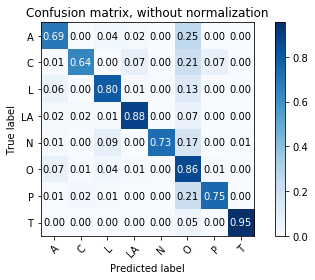

In [478]:
plot_confusion_matrix(straight(y_test),straight(y_pred), classes=labels,normalize=True,title='Confusion matrix, without normalization')

Confusion matrix, without normalization
[[1797    2   95   45    3  660    8    0]
 [   2  204    1   24    1   66   22    0]
 [ 111    0 1449   14    9  236    1    0]
 [  17   16    8  908    2   74    2    0]
 [   3    0   31    0  257   60    0    2]
 [ 465   34  247   53   33 5763   67   12]
 [   3   10    4    0    0   87  309    0]
 [   0    0    0    0    0   14    0  288]]


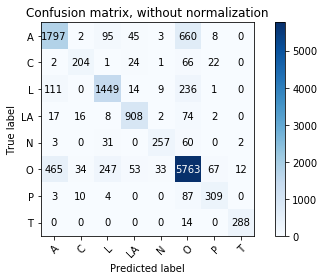

In [479]:
plot_confusion_matrix(straight(y_test),straight(y_pred), classes=labels,normalize=False,title='Confusion matrix, without normalization')